# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

In [63]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import pandas as pd
import matplotlib.pyplot as plt

from pyproj import CRS
import contextily as ctx

import osmnx as ox
import networkx as nx

In [64]:
origin_pt = pd.read_csv(r'data/origins.csv')
dest_pt = pd.read_csv(r'data/destinations.csv')

In [65]:
origin_pt.head()

,x,y
0,24.6159,59.4052
1,24.6407,59.4074
2,24.6686,59.4018
3,24.6980,59.4477
4,24.7680,59.4303


In [66]:
dest_pt.head()

,x,y
0,24.8441,59.4395
1,24.6150,59.3433
2,24.8656,59.4405
3,24.6983,59.4013
4,24.7630,59.4407


In [67]:
dest_pt['x'][0]

24.8441

# Convert points to shapely Points.

In [68]:
def create_point(x_coord,y_coord):
    return Point(x_coord, y_coord)

def create_list_of_points(df):
    geom = []
    
    for index in range(0, len(df)):
        geom.append( create_point( df.at[index, 'x'], df.at[index, 'y'] ) )
     
    return geom

origin_pt['geometry'] = create_list_of_points(origin_pt)
dest_pt['geometry'] = create_list_of_points(dest_pt)

In [69]:
origin_pt.head()

,x,y,geometry
0,24.6159,59.4052,POINT (24.6159 59.4052)
1,24.6407,59.4074,POINT (24.6407 59.4074)
2,24.6686,59.4018,POINT (24.6686 59.4018)
3,24.6980,59.4477,POINT (24.698 59.4477)
4,24.7680,59.4303,POINT (24.768 59.4303)


In [70]:
dest_pt.head()

,x,y,geometry
0,24.8441,59.4395,POINT (24.8441 59.4395)
1,24.6150,59.3433,POINT (24.615 59.3433)
2,24.8656,59.4405,POINT (24.8656 59.4405)
3,24.6983,59.4013,POINT (24.6983 59.4013)
4,24.7630,59.4407,POINT (24.763 59.4407)


# Concatenate  the destination and origin points into a single df

In [71]:
all_points = pd.concat ([ origin_pt, dest_pt], axis=0, ignore_index=True)

all_points.head()

,x,y,geometry
0,24.6159,59.4052,POINT (24.6159 59.4052)
1,24.6407,59.4074,POINT (24.6407 59.4074)
2,24.6686,59.4018,POINT (24.6686 59.4018)
3,24.6980,59.4477,POINT (24.698 59.4477)
4,24.7680,59.4303,POINT (24.768 59.4303)


In [72]:
print("origin pt: ", len(origin_pt) )

print("destination pt: ", len(dest_pt) )

print("total pts: ", len(all_points) )

origin pt:  16
destination pt:  20
total pts:  36


In [73]:
#create a geodataframe of all points
all_points_gdf = gpd.GeoDataFrame( all_points, geometry=all_points['geometry'] )

In [74]:
print(all_points_gdf.crs)

None


In [75]:
#set projection to 4326 WGS84, 
#(this command only updates the metadata about coordinate reference system which is stored in the class variable .crs, and does not modify the actual coordinate values.)
all_points_gdf.crs = CRS.from_epsg(4326)

#re-project geometry to 4326 WGS84, and redefine the .crs
all_points_gdf = all_points_gdf.to_crs( CRS.from_epsg(4326) )

# Plot points on basemap

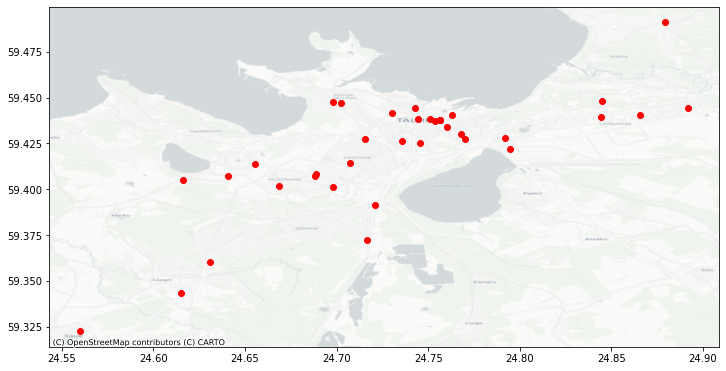

In [76]:
fig, ax = plt.subplots(figsize= (12,8))

#polygon_gdf.plot(ax=ax, facecolor='dimgray')

all_points_gdf.plot(ax=ax, facecolor= 'red')

ctx.add_basemap(ax=ax, crs=all_points_gdf.crs, source=ctx.providers.CartoDB.Positron)

In [77]:
all_points_gdf.head()

,x,y,geometry
0,24.6159,59.4052,POINT (24.61590 59.40520)
1,24.6407,59.4074,POINT (24.64070 59.40740)
2,24.6686,59.4018,POINT (24.66860 59.40180)
3,24.6980,59.4477,POINT (24.69800 59.44770)
4,24.7680,59.4303,POINT (24.76800 59.43030)


In [78]:
all_points_gdf.dtypes

x            float64
y            float64
geometry    geometry
dtype: object

In [79]:
all_points_gdf.at[1, 'y']

59.4074

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [80]:
from geopy.geocoders import Nominatim

row = 0
#take a location and grab the state, country, city (format = lat , lon)
coords = "{val1},{val2}".format( val1 = all_points_gdf.at[row, 'y'], val2 = all_points_gdf.at[row, 'x'] )
geolocator = Nominatim(user_agent="L6_exercise")
location = geolocator.reverse(coords)

print("Address of points: ", location.address)

Address of points:  Astangu Rimi super, 4, Kotermaa, Astangu, Haabersti linnaosa, Tallinn, Harju maakond, 13524, Eesti


**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located*. 
- Store the extent as a Shapely Polygon stored in a variable called `graph_extent`.
- Add a little bit of buffer around the extent for downloading the graph, so that you cover all routes between the points.
- See hints from this [week's hints page](https://autogis-site.readthedocs.io/en/latest/lessons/L6/exercise-6.html#hints) on how to define the extent.

# Create a bounding box of area

- Create a multipoint from individual points

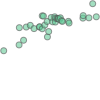

In [81]:
union_of_all_points = all_points_gdf.unary_union
union_of_all_points

In [82]:
print(union_of_all_points)

MULTIPOINT (24.5598 59.3224, 24.615 59.3433, 24.6159 59.4052, 24.6311 59.3601, 24.6407 59.4074, 24.6552 59.4135, 24.6686 59.4018, 24.6882 59.4074, 24.6887 59.4085, 24.698 59.4477, 24.6983 59.4013, 24.7023 59.4469, 24.7072 59.4145, 24.7157 59.4275, 24.7167 59.3721, 24.7212 59.3912, 24.7301 59.4415, 24.7356 59.4262, 24.7428 59.4442, 24.7446 59.4381, 24.7453 59.4254, 24.7508 59.4383, 24.7536 59.437, 24.7562 59.4377, 24.7563 59.4377, 24.7604 59.4342, 24.763 59.4407, 24.768 59.4303, 24.77 59.4276, 24.7918 59.4279, 24.7944 59.4219, 24.8441 59.4395, 24.845 59.4484, 24.8656 59.4405, 24.8792 59.4912, 24.8921 59.4442)


- Create (1) minimum boundary polygon that encompasses all points


The convex hull of a geometry is the smallest convex Polygon containing all the points in each geometry, unless the number of points in the geometric object is less than three. For two points, the convex hull collapses to a LineString; for 1, a Point.

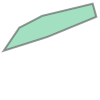

In [83]:
graph_extent = union_of_all_points.convex_hull

graph_extent

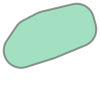

In [84]:
#buffer the convex hull polygon (eg. adding 0.1 decimal degrees to the extent using Shapely’s buffer method)
buffered_polygon= graph_extent.buffer(0.1)
buffered_polygon

In [85]:
polygon_gdf = gpd.GeoSeries( [ buffered_polygon] )

polygon_gdf.head()

0    POLYGON ((24.59000 59.22707, 24.58043 59.22455...
dtype: geometry

In [86]:
print(polygon_gdf.crs)

None


In [87]:
#set projection to 4326 WGS84, 
#(this command only updates the metadata about coordinate reference system which is stored in the class variable .crs, and does not modify the actual coordinate values.)
polygon_gdf.crs = CRS.from_epsg(4326)

#re-project geometry to 4326 WGS84, and redefine the .crs
polygon_gdf = polygon_gdf.to_crs( CRS.from_epsg(4326) )

In [88]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(graph_extent)

POLYGON ((24.5598 59.3224, 24.6159 59.4052, 24.698 59.4477, 24.8792 59.4912, 24.8921 59.4442, 24.7167 59.3721, 24.5598 59.3224))


In [89]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(graph_extent))

<class 'shapely.geometry.polygon.Polygon'>


In [90]:
polygon_gdf.head()

0    POLYGON ((24.59000 59.22707, 24.58043 59.22455...
dtype: geometry

- Use the polygon to fetch the drivable network data with `.graph_from_polygon()` function 
- Remember to specify correct `network_type`
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

In [91]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
#retrieve the network
graph = ox.graph_from_polygon(polygon_gdf.values[0], network_type='drive')

In [92]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [93]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 28756 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

29296


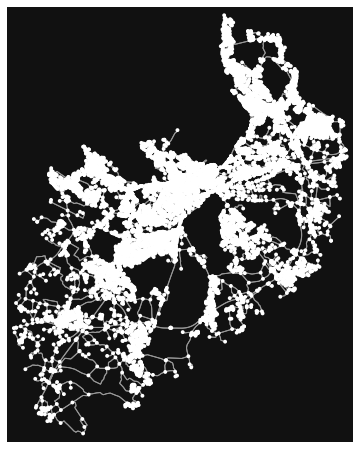

In [94]:
#plot the streets
fig, ax = ox.plot_graph(graph)

In [95]:
#retrieve nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

In [96]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
6920814,59.446680,24.926537,3,NaN,POINT (24.92654 59.44668)
10578472,59.428396,24.723404,3,NaN,POINT (24.72340 59.42840)
10578481,59.438986,24.720409,3,NaN,POINT (24.72041 59.43899)
10578496,59.437414,24.723348,3,NaN,POINT (24.72335 59.43741)
10578534,59.430780,24.713766,3,NaN,POINT (24.71377 59.43078)


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

# Retrieve streets from the graph

In [97]:
#retrieve only edges from the graph convert to geodataframe
streets = ox.graph_to_gdfs(graph, nodes=False, edges=True)

print(streets.columns)

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'length', 'geometry', 'tunnel', 'junction', 'width', 'bridge',
       'access'],
      dtype='object')


In [98]:
streets.head()

osmid  oneway lanes  ref           name  \
u        v          key                                               
6920814  11279496   0    91563671    True     3    1  Peterburi tee   
         1584679220 0    97114010    True     1  NaN            NaN   
10578472 243943723  0    47854217   False   NaN  NaN         Madara   
         75704748   0    27457613    True   NaN  NaN         Madara   
10578481 10578496   0    40389091   False   NaN  NaN           Rohu   

                             highway maxspeed   length  \
u        v          key                                  
6920814  11279496   0          trunk       90  418.566   
         1584679220 0     trunk_link      NaN  233.270   
10578472 243943723  0    residential      NaN   55.915   
         75704748   0    residential      NaN   84.921   
10578481 10578496   0    residential      NaN  241.221   

                                                                  geometry  \
u        v          key                                                      
6920814  11279496   0    LINESTRING (24.92654 59.44668, 24.92791 59.446...   
         1584679220 0    LINESTRING (24.92654 59.44668, 24.92747 59.446...   
10578472 243943723  0    LINESTRING (24.72340 59.42840, 24.72303 59.42886)   
         75704748   0    LINESTRING (24.72340 59.42840, 24.72346 59.428...   
10578481 10578496   0    LINESTRING (24.72041 59.43899, 24.72335 59.43741)   

                        tunnel junction width bridge access  
u        v          key                                      
6920814  11279496   0      NaN      NaN   NaN    NaN    NaN  
         1584679220 0      NaN      NaN   NaN    NaN    NaN  
10578472 243943723  0      NaN      NaN   NaN    NaN    NaN  
         75704748   0      NaN      NaN   NaN    NaN    NaN  
10578481 10578496   0      NaN      NaN   NaN    NaN    NaN

In [99]:
#covert origin pt to gdf for plotting
origin_gdf = gpd.GeoDataFrame(origin_pt, geometry=gpd.points_from_xy(origin_pt['x'], origin_pt['y'] ))

origin_gdf.head()

,x,y,geometry
0,24.6159,59.4052,POINT (24.61590 59.40520)
1,24.6407,59.4074,POINT (24.64070 59.40740)
2,24.6686,59.4018,POINT (24.66860 59.40180)
3,24.6980,59.4477,POINT (24.69800 59.44770)
4,24.7680,59.4303,POINT (24.76800 59.43030)


In [100]:
#covert dest pt to gdf for plotting
dest_gdf = gpd.GeoDataFrame(dest_pt, geometry=gpd.points_from_xy(dest_pt['x'], dest_pt['y'] ))

dest_gdf.head()

,x,y,geometry
0,24.8441,59.4395,POINT (24.84410 59.43950)
1,24.6150,59.3433,POINT (24.61500 59.34330)
2,24.8656,59.4405,POINT (24.86560 59.44050)
3,24.6983,59.4013,POINT (24.69830 59.40130)
4,24.7630,59.4407,POINT (24.76300 59.44070)


In [101]:
#set projection to 4326 WGS84, 
#(this command only updates the metadata about coordinate reference system which is stored in the class variable .crs, and does not modify the actual coordinate values.)
origin_gdf.crs = CRS.from_epsg(4326)

#re-project geometry to 4326 WGS84, and redefine the .crs
origin_gdf = origin_gdf.to_crs( CRS.from_epsg(4326) )

In [102]:
#set projection to 4326 WGS84, 
#(this command only updates the metadata about coordinate reference system which is stored in the class variable .crs, and does not modify the actual coordinate values.)
dest_gdf.crs = CRS.from_epsg(4326)

#re-project geometry to 4326 WGS84, and redefine the .crs
dest_gdf = dest_gdf.to_crs( CRS.from_epsg(4326) )

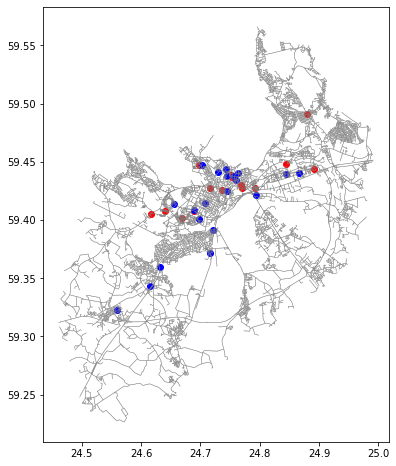

In [103]:
fig, ax = plt.subplots( figsize=(12,8) )

ax = streets.plot(ax = ax, color = 'gray', linewidth=0.5, alpha=0.7)
ax = origin_gdf.plot(ax= ax, facecolor='red')
ax=  dest_gdf.plot(ax=ax, facecolor='blue' )

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [300]:
# Store the shortest path routes as LineString geometries in a GeoDataFrame called routes:
routes_geom_list = []

In [105]:
#test extract each row
origin_gdf.iloc[0,]

x                           24.6159
y                           59.4052
geometry    POINT (24.6159 59.4052)
Name: 0, dtype: object

In [106]:
#find the node in te graph that is closest to the origin point( here, we want to get the node id)
def get_nearest_node_id(row,graph):
    
    #point needs to be in lat, long format
    point =  (row['y'], row['x'])
    
    node_id = ox.get_nearest_node(graph, point, method='euclidean')
    
    return node_id

def get_list_node_id(gdf,graph):
    
    id_list = [] 
    
    for index in range(0, len(gdf)):
        
        #get the nearest node in the graph given each row
        id_list.append( get_nearest_node_id( gdf.iloc[index,], graph) )
        
    return id_list

In [107]:
#get nearest node for each origin point
origin_gdf['nearest_node'] = get_list_node_id(origin_gdf, graph)

origin_gdf

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warning

,x,y,geometry,nearest_node
0,24.6159,59.4052,POINT (24.61590 59.40520),341986868
1,24.6407,59.4074,POINT (24.64070 59.40740),297425570
2,24.6686,59.4018,POINT (24.66860 59.40180),1262556101
3,24.6980,59.4477,POINT (24.69800 59.44770),1769386593
4,24.7680,59.4303,POINT (24.76800 59.43030),10580988
5,24.7918,59.4279,POINT (24.79180 59.42790),7129214038
6,24.7536,59.4370,POINT (24.75360 59.43700),31288160
7,24.8792,59.4912,POINT (24.87920 59.49120),8035654283
8,24.6882,59.4074,POINT (24.68820 59.40740),2094699826
9,24.7356,59.4262,POINT (24.73560 59.42620),312958791


In [108]:
#get nearest node for each dest point
dest_gdf['nearest_node'] = get_list_node_id(dest_gdf, graph)

dest_gdf

C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Anaconda\envs\python-gis\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warning

,x,y,geometry,nearest_node
0,24.8441,59.4395,POINT (24.84410 59.43950),614466115
1,24.6150,59.3433,POINT (24.61500 59.34330),3092027759
2,24.8656,59.4405,POINT (24.86560 59.44050),2571675809
3,24.6983,59.4013,POINT (24.69830 59.40130),11790828
4,24.7630,59.4407,POINT (24.76300 59.44070),790046528
5,24.6552,59.4135,POINT (24.65520 59.41350),306940027
6,24.7167,59.3721,POINT (24.71670 59.37210),2505605108
7,24.7428,59.4442,POINT (24.74280 59.44420),11782860
8,24.7562,59.4377,POINT (24.75620 59.43770),11783954
9,24.6311,59.3601,POINT (24.63110 59.36010),385912627


**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [164]:
pd.DataFrame(nodes.loc[256061995,]).transpose()

,y,x,street_count,highway,geometry
256061995,59.405998,24.616347,3,traffic_signals,POINT (24.6163474 59.4059976)


In [147]:
pd.DataFrame(nodes).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12518 entries, 6920814 to 9542668205
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             12518 non-null  float64 
 1   x             12518 non-null  float64 
 2   street_count  12518 non-null  int64   
 3   highway       403 non-null    object  
 4   geometry      12518 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 844.8+ KB


In [301]:
for origin_index in range(0, len(origin_gdf)):
    
    for dest_index in range(0, len(dest_gdf)):
        
        #if origin node and destination node are the same skip the nearest node calculation
        if ( origin_gdf.at[origin_index, 'nearest_node'] == dest_gdf.at[dest_index, 'nearest_node'] ):
            
            nearest_node_origin_geometry = nodes.loc[ origin_gdf.at[origin_index, 'nearest_node'], 'geometry']
            nearest_node_dest_geometry = nodes.loc[ dest_gdf.at[dest_index, 'nearest_node'], 'geometry']
            
            routes_geom_list.append( LineString( [nearest_node_origin_geometry, nearest_node_dest_geometry] ) )
        
        else:
            #calculate the shortest path
            source = origin_gdf.at[origin_index, 'nearest_node']
            target = dest_gdf.at[dest_index, 'nearest_node' ]
            
            #returns a list of nodes ids
            shortest_path = nx.shortest_path(G=graph, source=source, target=target, weight='length' )
            
            #extract all rows with ids found in shortest_path list
            route_nodes = pd.DataFrame()
            
            for index in range(0,len(shortest_path)):
                
                if index == 0:
                    ##extract node attributes using nodes id, convert row from series to dataframe 
                    route_nodes = pd.DataFrame(nodes.loc[shortest_path[index],]).transpose()
                else:
                    route_nodes = pd.concat( [ route_nodes,  pd.DataFrame(nodes.loc[shortest_path[index],]).transpose() ] )
            
            #convert row to a geodataframe
            route_nodes = gpd.GeoDataFrame(route_nodes,geometry='geometry',crs= nodes.crs)
            
            #convert gdf geometry gdf series to a list of points, create a linestring object with the list of points.
            routes_geom_list.append( LineString( list(route_nodes.geometry.values) ) )   

In [302]:
#cross join to create a mapping of each origin pt to each dest point (16 origin pts to 20 dest pts = 320 total routes)
cross_join = origin_gdf.merge(dest_gdf, how='cross')
cross_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   x_x             320 non-null    float64 
 1   y_x             320 non-null    float64 
 2   geometry_x      320 non-null    geometry
 3   nearest_node_x  320 non-null    int64   
 4   x_y             320 non-null    float64 
 5   y_y             320 non-null    float64 
 6   geometry_y      320 non-null    geometry
 7   nearest_node_y  320 non-null    int64   
dtypes: float64(4), geometry(2), int64(2)
memory usage: 22.5 KB


In [282]:
#rename column labels for origin and dest points

In [311]:
routes = cross_join.rename(columns={
                            'x_x': 'origin_x', 
                           'y_x':'origin_y',
                           'x_y': 'dest_x',
                           'y_y': 'dest_y'
                          }
                 )

In [312]:
routes.head()

,origin_x,origin_y,geometry_x,nearest_node_x,dest_x,dest_y,geometry_y,nearest_node_y
0,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8441,59.4395,POINT (24.84410 59.43950),614466115
1,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6150,59.3433,POINT (24.61500 59.34330),3092027759
2,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8656,59.4405,POINT (24.86560 59.44050),2571675809
3,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6983,59.4013,POINT (24.69830 59.40130),11790828
4,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.7630,59.4407,POINT (24.76300 59.44070),790046528


In [313]:
routes['shortest_path'] = routes_geom_list

In [314]:
routes.head()

,origin_x,origin_y,geometry_x,nearest_node_x,dest_x,dest_y,geometry_y,nearest_node_y,shortest_path
0,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8441,59.4395,POINT (24.84410 59.43950),614466115,"LINESTRING (24.6169895 59.4057332, 24.6163474 ..."
1,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6150,59.3433,POINT (24.61500 59.34330),3092027759,"LINESTRING (24.6169895 59.4057332, 24.6163474 ..."
2,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8656,59.4405,POINT (24.86560 59.44050),2571675809,"LINESTRING (24.6169895 59.4057332, 24.6163474 ..."
3,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6983,59.4013,POINT (24.69830 59.40130),11790828,"LINESTRING (24.6169895 59.4057332, 24.6285594 ..."
4,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.7630,59.4407,POINT (24.76300 59.44070),790046528,"LINESTRING (24.6169895 59.4057332, 24.6163474 ..."


In [315]:
routes = gpd.GeoDataFrame(routes,geometry='shortest_path',crs=CRS.from_epsg(4326)) #nodes crs projection

#re-project the geometry column to 3301
routes = routes.to_crs( CRS.from_epsg(3301) )

In [316]:
routes.head()

,origin_x,origin_y,geometry_x,nearest_node_x,dest_x,dest_y,geometry_y,nearest_node_y,shortest_path
0,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8441,59.4395,POINT (24.84410 59.43950),614466115,"LINESTRING (535043.627 6585473.961, 535006.888..."
1,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6150,59.3433,POINT (24.61500 59.34330),3092027759,"LINESTRING (535043.627 6585473.961, 535006.888..."
2,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8656,59.4405,POINT (24.86560 59.44050),2571675809,"LINESTRING (535043.627 6585473.961, 535006.888..."
3,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6983,59.4013,POINT (24.69830 59.40130),11790828,"LINESTRING (535043.627 6585473.961, 535701.678..."
4,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.7630,59.4407,POINT (24.76300 59.44070),790046528,"LINESTRING (535043.627 6585473.961, 535006.888..."


In [317]:
routes['route_dist'] = routes['shortest_path'].length

In [318]:
routes.head()

,origin_x,origin_y,geometry_x,nearest_node_x,dest_x,dest_y,geometry_y,nearest_node_y,shortest_path,route_dist
0,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8441,59.4395,POINT (24.84410 59.43950),614466115,"LINESTRING (535043.627 6585473.961, 535006.888...",14757.749147
1,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6150,59.3433,POINT (24.61500 59.34330),3092027759,"LINESTRING (535043.627 6585473.961, 535006.888...",8805.939968
2,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.8656,59.4405,POINT (24.86560 59.44050),2571675809,"LINESTRING (535043.627 6585473.961, 535006.888...",16065.115473
3,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.6983,59.4013,POINT (24.69830 59.40130),11790828,"LINESTRING (535043.627 6585473.961, 535701.678...",5244.162813
4,24.6159,59.4052,POINT (24.61590 59.40520),341986868,24.7630,59.4407,POINT (24.76300 59.44070),790046528,"LINESTRING (535043.627 6585473.961, 535006.888...",10241.138131


In [321]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

Shortest distance: 0 meters


In [320]:
# NON-EDITABLE TEST CELL (longest distance in the example solution is 29177 meters)
print("Longest distance:", round(routes['route_dist'].max()), "meters")

Longest distance: 28727 meters


**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

In [327]:
#reproject edges to epsg:3301 to plot overlay routes data

#re-project the geometry column to 3301
edges = edges.to_crs( CRS.from_epsg(3301) )

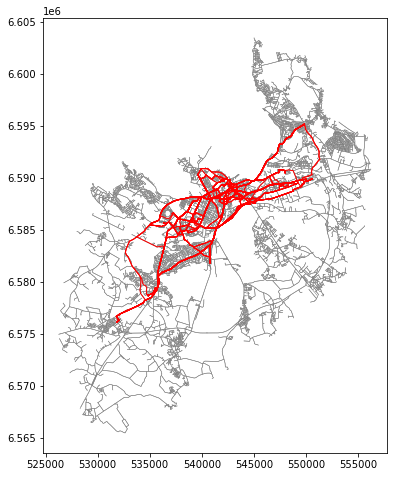

In [328]:
fig, ax = plt.subplots(figsize=(12,8))
ed = edges.plot(ax=ax, color='grey', linewidth=0.5)
rt = routes.plot(ax=ed,color='red', linewidth=1)

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [330]:
total_distance = routes['route_dist'].sum()

In [331]:
# NON-EDITABLE TEST CELL (example solution: 2468 kilometers)
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


Total distance of all routes is: 2461 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)